# Importing necessary packages and functions

In [1]:
!pip install pm4py
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.7
    Uninstalling torch-sparse-0.6.7:
      Successfully uninstalled torch-sparse-0.6.7
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.7
    Uninstalling torch-cluster-1.5.7:
      Successfully uninstalled torch-cluster-1.5.7
Looking in links: https

In [2]:
import pandas as pd
import time
from datetime import datetime
import numpy as np
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.linalg import fractional_matrix_power

import torch 
import torch.nn as nn
from torch.nn import Parameter
#from torch_geometric.nn.inits import glorot, zeros

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm
from pm4py.objects.conversion.dfg import converter as dfg_conv
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.visualization.dfg import visualizer as dfg_vis_fact
from pm4py.visualization.petrinet import visualizer as pn_vis

In [4]:
# from torch_geometric.nn.inits import glorot, zeros 

#Unable to import above line, so manually copy-pasting the source code

import math

def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)

def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

In [5]:
import bisect
import warnings
from torch._utils import _accumulate
from torch import randperm, default_generator

class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)
        
def random_split(dataset, lengths, generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting the parameters

In [6]:
# Helpdesk dataset

path = '/content/drive/My Drive/MSc Dissertation/Data/helpdesk.csv'
save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/helpdesk'
num_nodes = 9

# # BPI dataset

# path = '/content/drive/My Drive/MSc Dissertation/Data/bpi_12_w.csv'
# save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/bpi'
# num_nodes = 6 

# # BPI dataset (No Repeats)

# path = '/content/drive/My Drive/MSc Dissertation/Data/bpi_12_w_no_repeat.csv'
# save_folder = '/content/drive/My Drive/MSc Dissertation/Final GCN Model/dump/bpi_no_repeat'
# num_nodes = 6 

num_features = 4
showProcessGraph = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cuda'
num_epochs = 100
seed_value = 42
lr_value = 1e-05
weighted_adjacency = False
binary_adjacency = True
laplacian_matrix = True
variant = 'laplacianOnBinary'

# Data Pre-processing

In [7]:
def generate_features (df,total_activities,num_features):
  lastcase = ''
  firstLine = True
  numlines = 0
  casestarttime = None
  lasteventtime = None
  features = []

  for i,row in df.iterrows():
    t = time.strptime(row[2], "%Y-%m-%d %H:%M:%S")
    if row[0]!=lastcase:
        casestarttime = t
        lasteventtime = t
        lastcase = row[0]
        numlines+=1
    timesincelastevent = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(lasteventtime))
    timesincecasestart = datetime.fromtimestamp(time.mktime(t))-datetime.fromtimestamp(time.mktime(casestarttime))
    midnight = datetime.fromtimestamp(time.mktime(t)).replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = datetime.fromtimestamp(time.mktime(t))-midnight
    timediff = 86400 * timesincelastevent.days + timesincelastevent.seconds
    timediff2 = 86400 * timesincecasestart.days + timesincecasestart.seconds
    timediff3 = timesincemidnight.seconds #this leaves only time even occured after midnight
    timediff4 = datetime.fromtimestamp(time.mktime(t)).weekday() #day of the week
    lasteventtime = t
    firstLine = False
    feature_list = [timediff,timediff2,timediff3,timediff4]
    features.append(feature_list)

  df['Feature Vector'] = features
  
  firstLine = True
  NN_features =[]

  for i,row in df.iterrows():
    if firstLine:
      features = np.zeros((total_activities,num_features))
      features[row[1] - 1] = row[3]
      firstLine = False
    else:
      if (row[3][0] == 0):
        features = np.zeros((total_activities,num_features))
        features[row[1] - 1] = row[3]
      else:
        features = np.copy(prev_row_features)
        features[row[1] - 1] = row[3]
    prev_row_features = features
    NN_features.append(features)  
  
  return NN_features

In [8]:
def generate_labels(df,total_activities):
  next_activity = []
  next_timestamp = []

  for i,row in df.iterrows():
    if (i != 0):
      if (row[3][0]==0):
        next_activity.append(total_activities)
      else:
        next_activity.append(row[1]-1)
  next_activity.append(total_activities)
  for i,row in df.iterrows():
    if (i != 0):
      if (row[3][0]==0):
        next_timestamp.append(0)
      else:
        next_timestamp.append(row[3][2])
  next_timestamp.append(0)

  return next_activity,next_timestamp

In [9]:
class EventLogData(Dataset):
  def __init__ (self, input, output):
    self.X = input
    self.y = output
    self.y = self.y.to(torch.float32)
    self.y = self.y.reshape((len(self.y),1))

  #get the number of rows in the dataset
  def __len__(self):
    return len(self.X)

  #get a row at a particular index in the dataset
  def __getitem__ (self,idx):
    return [self.X[idx],self.y[idx]]
  
  # get the indices for the train and test rows
  def get_splits(self, n_test = 0.33, n_valid = 0.2):
    test_size = round(n_test * len(self.X))
    valid_size = round( n_valid * (len(self.X) - test_size) )
    train_size = len(self.X) - ( test_size + valid_size )
    return random_split(self, [train_size, valid_size, test_size],generator=torch.Generator().manual_seed(seed_value))

In [10]:
def prepare_data_for_Predictor(NN_features,label):
  dataset = EventLogData(NN_features,label)
  train, valid, test = dataset.get_splits()
  train_dl = DataLoader(train, batch_size=1, shuffle = True)
  valid_dl = DataLoader(valid, batch_size=1, shuffle = False)
  test_dl = DataLoader(test, batch_size = 1, shuffle = False)
  return train_dl, valid_dl, test_dl

In [11]:
def generate_input_and_labels (path):
  df = pd.read_csv(path)
  total_unique_activities = num_nodes
  NN_features = generate_features(df,total_unique_activities,num_features)
  next_activity, next_timestamp = generate_labels(df,total_unique_activities)
  NN_features = torch.Tensor(NN_features).to(torch.float32)
  next_activity = torch.Tensor(next_activity).to(torch.float32)
  next_timestamp = torch.Tensor(next_timestamp).to(torch.float32)
 
  train_dl, valid_dl, test_dl = prepare_data_for_Predictor(NN_features, next_activity)
  #train_dl, test_dl = prepare_data_for_Predictor(NN_features, next_timestamp)
  
  return train_dl,valid_dl,test_dl

# Getting Adjacency Matrix from Process Graph

In [12]:
def generate_process_graph (path):
  data = pd.read_csv(path)
  num_nodes = data['ActivityID'].nunique() # 9 for helpdesk.csv
  cols = ['case:concept:name','concept:name','time:timestamp']
  data.columns = cols 
  data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])
  data['concept:name'] = data['concept:name'].astype(str)
  log = log_converter.apply(data, variant=log_converter.Variants.TO_EVENT_LOG)
  dfg = dfg_algorithm.apply(log)
  if showProcessGraph:
    visualize_process_graph(dfg,log)
  max = 0
  min = 0
  adj = np.zeros((num_nodes,num_nodes))
  for k,v in dfg.items():
    for i in range(num_nodes):
      if(k[0] == str(i+1)):
        for j in range(num_nodes):
          if (k[1] == str(j+1)):
            adj[i][j] = v
            if (v > max): max=v
            if (v< min): min=v

  print("Raw weighted adjacency matrix: {}".format(adj))
  
  # for i in range(num_nodes):
  #   for j in range(num_nodes):
  #     adj[i][j] = (adj[i][j] - min)/(max - min)

  # print("Min-Max normalised weighted adjacency matrix: {}".format(adj))

  if binary_adjacency:
    for i in range(num_nodes):
      for j in range(num_nodes):
        if (adj[i][j]!=0):
          adj[i][j]=1
    print("Binary adjacency matrix: {}".format(adj))
  
  D = np.array(np.sum(adj, axis=1))
  D = np.matrix(np.diag(D))
  print("Degree matrix: {}".format(D))
  
  adj = np.matrix(adj)

  if laplacian_matrix:
    adj = D - adj # Laplacian Transform 
    print("Laplacian matrix: {}".format(adj))

  # adj = (D**-1)*adj
  adj = fractional_matrix_power(D, -0.5)*adj*fractional_matrix_power(D, -0.5)
  adj = torch.Tensor(adj).to(torch.float)
  
  print("Symmetrically normalised Adjacency matrix: {}".format(adj))
  
  return adj

In [13]:
def visualize_process_graph (dfg,log):
  dfg_gv = dfg_vis_fact.apply(dfg, log, parameters={dfg_vis_fact.Variants.FREQUENCY.value.Parameters.FORMAT: "jpeg"})
  dfg_vis_fact.view(dfg_gv)
  dfg_vis_fact.save(dfg_gv,"dfg.jpg")

# Building Model

In [14]:
class GCNConv(torch.nn.Module):
    def __init__(self, num_nodes, num_features, out_channels):
        super(GCNConv, self).__init__()

        self.in_channels = num_features
        self.out_channels = out_channels

        self.weight = Parameter(torch.Tensor(num_features, out_channels))
        self.bias = Parameter(torch.Tensor(num_nodes))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def forward(self, x, adj):
        x = adj@x@self.weight
        x = torch.flatten(x)
        x = x + self.bias
        return x

In [15]:
class EventPredictor(torch.nn.Module):
    def __init__(self,num_nodes, num_features = 4):
        super(EventPredictor, self).__init__()

        self.layer1 = GCNConv(num_nodes, num_features, out_channels=1)
        self.layer2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(num_nodes,256),
            nn.Tanh(),
            nn.Linear(256,256),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(256,num_nodes+1),
        )

    def forward(self, x, adj):
        x = self.layer1(x,adj)
        x = self.layer2(x)
        # x = torch.sigmoid(x)
        return x

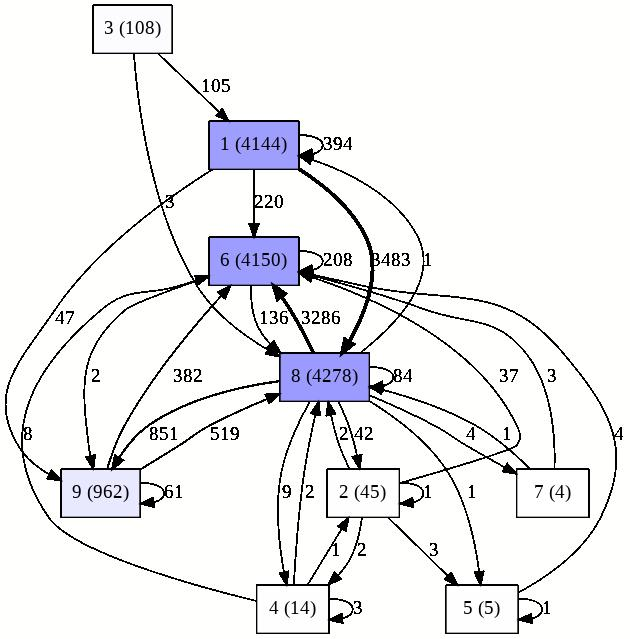

Raw weighted adjacency matrix: [[3.940e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.200e+02 0.000e+00
  3.483e+03 4.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 2.000e+00 3.000e+00 3.700e+01 0.000e+00
  2.000e+00 0.000e+00]
 [1.050e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 3.000e+00 0.000e+00 8.000e+00 0.000e+00
  2.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 4.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.080e+02 0.000e+00
  1.360e+02 2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
  1.000e+00 0.000e+00]
 [1.000e+00 4.200e+01 0.000e+00 9.000e+00 1.000e+00 3.286e+03 4.000e+00
  8.400e+01 8.510e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.820e+02 0.000e+00
  5.190e+02 6.100e+01]]
Binary adjacency matrix: [[1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0.

In [16]:
model = EventPredictor(num_nodes, num_features)
train_dl,valid_dl,test_dl = generate_input_and_labels(path)
adj = generate_process_graph(path)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr_value)
print("************* Event Predictor ***************")
print("Train size: {}, Validation size:{}, Test size: {}".format(len(train_dl.dataset),len(valid_dl.dataset),len(test_dl.dataset)))
print(model)

# Training the model 

In [17]:
model = model.to(device)
adj = adj.to(device)
epochs_plt = []
acc_plt = []
loss_plt = []
valid_loss_plt = []

for epoch in range(num_epochs):
    
    model.train()
    num_train = 0
    training_loss = 0
    predictions, actuals = list(),list()

    for i, (inputs,targets) in enumerate(train_dl):

      inputs,targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad() # Clearing the gradients
     
      yhat = model(inputs[0],adj)
      
      loss = criterion(yhat.reshape((1,-1)),targets[0].to(torch.long))
      loss.backward()
      optimizer.step()

      training_loss+= loss.item()

      yhat = yhat.to('cpu')
      yhat = torch.argmax(yhat)
      actual = targets.to('cpu')
      actual = actual[0]
      predictions.append(yhat)
      actuals.append(actual)
      num_train+=1

    with torch.no_grad():
      model.eval()
      num_valid = 0
      validation_loss = 0
      for i,(inputs,targets) in enumerate(valid_dl):
        inputs,targets = inputs.to(device),targets.to(device)
        yhat_valid = model(inputs[0],adj)
        loss_valid = criterion(yhat_valid.reshape((1,-1)),targets[0].to(torch.long))
        validation_loss+= loss_valid.item()
        num_valid+= 1

    acc = accuracy_score(actuals, predictions)
    avg_training_loss = training_loss/num_train
    avg_validation_loss = validation_loss/num_valid

    if (epoch==0): 
      best_loss = avg_validation_loss
      torch.save(model.state_dict(),'/content/EventPredictor_parameters.pt')
    
    if (avg_validation_loss < best_loss):
      torch.save(model.state_dict(),'/content/EventPredictor_parameters.pt')
      best_loss = avg_validation_loss
      
    print("Epoch: {}, Loss: {}, Accuracy: {}, Validation loss : {}".format(epoch,avg_training_loss,acc, avg_validation_loss))
    epochs_plt.append(epoch+1)
    acc_plt.append(acc)
    loss_plt.append(avg_training_loss)
    valid_loss_plt.append(avg_validation_loss)

Epoch: 0, Loss: 1.9484713885460212, Accuracy: 0.3973329704721731, Validation loss : 1.6221427657257685
Epoch: 1, Loss: 1.723310664805089, Accuracy: 0.521023268471901, Validation loss : 1.5028600248877744
Epoch: 2, Loss: 1.6154181912880006, Accuracy: 0.5607565655191182, Validation loss : 1.3908935220558227
Epoch: 3, Loss: 1.5005613472436883, Accuracy: 0.5867464961219213, Validation loss : 1.3023629588281322
Epoch: 4, Loss: 1.432153424909365, Accuracy: 0.596271601578446, Validation loss : 1.2248996974465376
Epoch: 5, Loss: 1.3363278666038483, Accuracy: 0.604027758878759, Validation loss : 1.1622643461760191
Epoch: 6, Loss: 1.2717276191748734, Accuracy: 0.6090624574772078, Validation loss : 1.1035957132822545
Epoch: 7, Loss: 1.2150786866081995, Accuracy: 0.6194040005442918, Validation loss : 1.06743663606205
Epoch: 8, Loss: 1.1891847165646903, Accuracy: 0.6198122193495714, Validation loss : 1.0412683827466918
Epoch: 9, Loss: 1.160759064559629, Accuracy: 0.6213090216355966, Validation loss

In [18]:
model.load_state_dict(torch.load('/content/EventPredictor_parameters.pt'))

<All keys matched successfully>

In [19]:
# if laplacian_matrix:
#   torch.save(model.state_dict(),'{}/EventPredictor_parameters_laplacian_{}.pt'.format(save_folder,lr_value))
# elif binary_adjacency:
#   torch.save(model.state_dict(),'{}/EventPredictor_parameters_binary_{}.pt'.format(save_folder,lr_value))
# else:
#   torch.save(model.state_dict(),'{}/EventPredictor_parameters_weighted_{}.pt'.format(save_folder,lr_value))

torch.save(model.state_dict(),'{}/EventPredictor_parameters_{}_{}.pt'.format(save_folder,variant,lr_value))

In [20]:
filepath = '/content/Accuracy_values.txt'
with open(filepath, 'w') as file:
    for item in zip(epochs_plt,acc_plt,loss_plt,valid_loss_plt):
        file.write("{}\n".format(item))

In [21]:
# if laplacian_matrix:
#   filepath = '{}/Accuracy_laplacian_{}.txt'.format(save_folder,lr_value)
# elif binary_adjacency:
#   filepath = '{}/Accuracy_binary_{}.txt'.format(save_folder,lr_value)
# else:
#   filepath = '{}/Accuracy_weighted_{}.txt'.format(save_folder,lr_value)

filepath = '{}/Accuracy_{}_{}.txt'.format(save_folder,variant,lr_value)

with open(filepath, 'w') as file:
    for item in zip(epochs_plt,acc_plt,loss_plt,valid_loss_plt):
        file.write("{}\n".format(item))

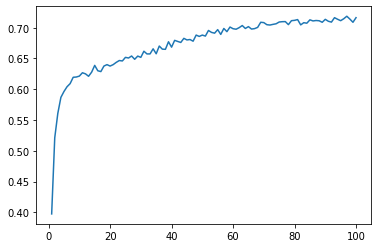

In [22]:
import matplotlib.pyplot as plt

plt.plot(epochs_plt,acc_plt)
plt.show()

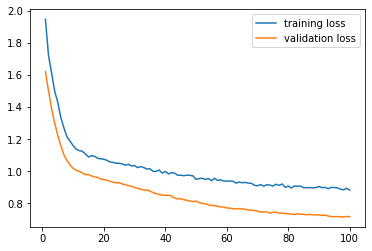

In [23]:
import matplotlib.pyplot as plt

plt.plot(epochs_plt,loss_plt, label = 'training loss')
plt.plot(epochs_plt,valid_loss_plt,label = 'validation loss')
plt.legend()
plt.show()

# Evaluating on Test Set

In [24]:
predictions, actuals = list(),list()

with torch.no_grad():
  model.eval()
  
  for i,(inputs,targets) in enumerate(test_dl):
    
    inputs,targets = inputs.to(device),targets.to(device)

    yhat = model(inputs[0],adj)
    #Retrieving predictions and true values as numpy arrays
    yhat = yhat.to('cpu')
    yhat = torch.argmax(yhat)
    actual = targets.to('cpu')
    actual = actual[0]
    predictions.append(yhat)
    actuals.append(actual)

#Calculating the accuracy
acc = accuracy_score(actuals, predictions)

In [25]:
acc

0.7747568523430592

# Making Predictions on Random data entries

In [26]:
# Making Predictions

df = pd.read_csv(path)
total_unique_activities = num_nodes
NN_features = generate_features(df,total_unique_activities,num_features)
next_activity, next_timestamp = generate_labels(df,total_unique_activities)
NN_features = torch.Tensor(NN_features).to(torch.float32)
next_activity = torch.Tensor(next_activity).to(torch.float32)
next_timestamp = torch.Tensor(next_timestamp).to(torch.float32)

print(NN_features[len(NN_features)-3])
input = NN_features[len(NN_features)-3].to(device)
predicted_activity = model(input,adj)
predicted_activity = predicted_activity.to('cpu')
predicted_activity = torch.argmax(predicted_activity)
print(predicted_activity)
print(next_activity[len(NN_features)-3])

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.6823e+04, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor(7)
tensor(8.)


In [27]:

print(NN_features[len(NN_features)-2])
input = NN_features[len(NN_features)-2].to(device)
predicted_activity = model(input,adj)
predicted_activity = predicted_activity.to('cpu')
predicted_activity = torch.argmax(predicted_activity)
print(predicted_activity)
print(next_activity[len(NN_features)-2])

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.6823e+04, 1.0000e+00],
        [6.2619e+05, 6.2619e+05, 1.8110e+03, 2.0000e+00]])
tensor(7)
tensor(5.)


In [28]:
print(NN_features[len(NN_features)-3])
input = NN_features[len(NN_features)-3].to(device)
predicted_activity = model(input,adj)
predicted_activity = predicted_activity.to('cpu')
predicted_activity = torch.argmax(predicted_activity)
print(predicted_activity)
print(next_activity[len(NN_features)-3])

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.6823e+04, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor(7)
tensor(8.)
